# Lab 3: Bayes Classifier and Boosting

## Jupyter notebooks

In this lab, you can use Jupyter <https://jupyter.org/> to get a nice layout of your code and plots in one document. However, you may also use Python as usual, without Jupyter.

If you have Python and pip, you can install Jupyter with `sudo pip install jupyter`. Otherwise you can follow the instruction on <http://jupyter.readthedocs.org/en/latest/install.html>.

And that is everything you need! Now use a terminal to go into the folder with the provided lab files. Then run `jupyter notebook` to start a session in that folder. Click `lab3.ipynb` in the browser window that appeared to start this very notebook. You should click on the cells in order and either press `ctrl+enter` or `run cell` in the toolbar above to evaluate all the expressions.

Be sure to put `%matplotlib inline` at the top of every code cell where you call plotting functions to get the resulting plots inside the document.

## Import the libraries

In Jupyter, select the cell below and press `ctrl + enter` to import the needed libraries.
Check out `labfuns.py` if you are interested in the details.

In [3]:
import numpy as np
from scipy import misc
from imp import reload
from labfuns import *
import random

## Bayes classifier functions to implement

The lab descriptions state what each function should do.

### Assignment 1.

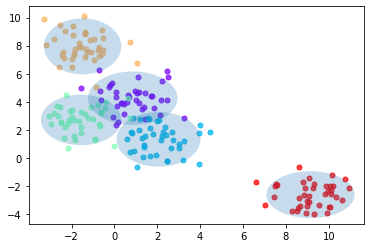

In [5]:
X, y = genBlobs()
mu, sigma = mlParams(X, y)
plotGaussian(X, y, mu, sigma)

### Assignment 2. 

In [6]:
prior = computePrior(y)
h = classifyBayes(X, prior, mu, sigma)

from scipy import spatial

result = 1 - spatial.distance.cosine(h, y)
result

0.9732116177760036

In [129]:
# NOTE: you do not need to handle the W argument for this part!
# in: labels - N vector of class labels
# out: prior - C x 1 vector of class priors
def computePrior(labels, W=None):
    Npts = labels.shape[0]
    ex = False
    if W is None:
        W = np.ones((Npts,1))/Npts
    else:
        assert(W.shape[0] == Npts)
    classes = np.unique(labels)
    Nclasses = np.size(classes)

    prior = np.zeros((Nclasses,1))

    # TODO: compute the values of prior for each class!
    # ==========================
    
    i = 0
    while i < Npts:
        li = labels[i]
        prior[li] += np.sum(W[li])
        i += 1

    prior /= np.sum(W)
    # ==========================
    
    return prior

# NOTE: you do not need to handle the W argument for this part!
# in:      X - N x d matrix of N data points
#     labels - N vector of class labels
# out:    mu - C x d matrix of class means (mu[i] - class i mean)
#      sigma - C x d x d matrix of class covariances (sigma[i] - class i sigma)
def mlParams(X, labels, W=None):
    assert(X.shape[0]==labels.shape[0])
    Npts,Ndims = np.shape(X)
    classes = np.unique(labels)
    Nclasses = np.size(classes)

    if W is None:
        W = np.ones((Npts,1))/float(Npts)

    mu = np.zeros((Nclasses,Ndims)) #4X2
    sigma = np.zeros((Nclasses,Ndims,Ndims)) #4X2X2
    
    a = np.zeros((Ndims, Ndims))
    np.fill_diagonal(a, 1)

    # TODO: fill in the code to compute mu and sigma!
    # ==========================
    for jdx, class_ in enumerate(classes):
        idx = labels == class_ # Returns a true or false with the length of y
                # Or more compactly extract the indices for which y==class is true,
                # analogous to MATLAB’s find
        
        idx = np.where(labels==class_)[0]
        xlc = X[idx,:] # Get the x for the class labels. Vectors are rows.
        
        
        if W is None:
            mu[jdx] = np.sum(xlc, axis = 0)/len(idx)
            sigma[jdx] = np.matmul(np.transpose((xlc-mu[jdx])), (xlc-mu[jdx]) ) * a /len(idx)
        else:
            wlc = W[idx,:]         
            mu[jdx] = np.sum((wlc*xlc), axis = 0)/np.sum(wlc, axis = 0)
            sigma[jdx] = np.matmul(np.transpose(wlc*(xlc-mu[jdx])), (xlc-mu[jdx]) ) * a \
            /np.sum(wlc, axis = 0)
    
    return mu, sigma

# in:      X - N x d matrix of N data points
#      prior - C x 1 matrix of class priors
#         mu - C x d matrix of class means (mu[i] - class i mean)
#      sigma - C x d x d matrix of class covariances (sigma[i] - class i sigma)
# out:     h - N vector of class predictions for test points
def classifyBayes(X, prior, mu, sigma):

    Npts = X.shape[0]
    Nclasses, Ndims = np.shape(mu)
    logProb = np.zeros((Nclasses, Npts))

    # TODO: fill in the code to compute the log posterior logProb!
    # ==========================
    
    for i in range(Npts):
        for jdx in range(Nclasses):
            logProb[jdx,i] = -0.5 * np.log(np.linalg.det(sigma[jdx])) \
            - 0.5 * np.matmul(np.matmul((X[i,:] - mu[jdx]) ,  np.linalg.inv(sigma[jdx])) , np.transpose((X[i,:] - mu[jdx]))) \
            + np.log(prior[jdx])
    
    # ==========================
    
    # one possible way of finding max a-posteriori once
    # you have computed the log posterior
    h = np.argmax(logProb, axis=0)
    return h

The implemented functions can now be summarized into the `BayesClassifier` class, which we will use later to test the classifier, no need to add anything else here:

In [130]:
# NOTE: no need to touch this
class BayesClassifier(object):
    def __init__(self):
        self.trained = False

    def trainClassifier(self, X, labels, W=None):
        rtn = BayesClassifier()
        rtn.prior = computePrior(labels, W)
        rtn.mu, rtn.sigma = mlParams(X, labels, W)
        rtn.trained = True
        return rtn

    def classify(self, X):
        return classifyBayes(X, self.prior, self.mu, self.sigma)

## Test the Maximum Likelihood estimates

Call `genBlobs` and `plotGaussian` to verify your estimates.

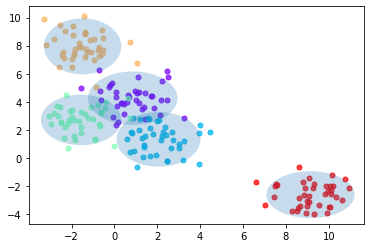

In [131]:
%matplotlib inline

X, labels = genBlobs(centers=5)
mu, sigma = mlParams(X,labels)
plotGaussian(X,labels,mu,sigma)

### Assignment 3

#### 1. When can a feature independence assumption be reasonable and when not?

It depends and its a matter of trial and error to analyse the different features to measure independance. However, most features have some form of dependance. For instance in the Iris features, the features are describing the flowers look. Its much like identifying a humans legs with its arms, if it is a long human, the human will have long arms and legs therefor the attributes are dependant. And an example of independance could be human length and eye color for instance. 

#### 2. How does the decision boundary look for the Iris dataset?

Where the clusters is overlapping. The decision boundary is not so well cut. 

#### 3. How could one improve the classifcation results for this scenario by changing classier or, alternatively, manipulating the data?

One way is to acknowledge dependance in the classfiyer. The other way is to change the features in which the data is not clustered in the same manner. 



Call the `testClassifier` and `plotBoundary` functions for this part.

In [132]:
testClassifier(BayesClassifier(), dataset='iris', split=0.7)

Trial: 0 Accuracy 84.4
Trial: 10 Accuracy 95.6
Trial: 20 Accuracy 93.3
Trial: 30 Accuracy 86.7
Trial: 40 Accuracy 88.9
Trial: 50 Accuracy 91.1
Trial: 60 Accuracy 86.7
Trial: 70 Accuracy 91.1
Trial: 80 Accuracy 86.7
Trial: 90 Accuracy 91.1
Final mean classification accuracy  89 with standard deviation 4.16


In [133]:
testClassifier(BayesClassifier(), dataset='vowel', split=0.7)

Trial: 0 Accuracy 61
Trial: 10 Accuracy 66.2
Trial: 20 Accuracy 74
Trial: 30 Accuracy 66.9
Trial: 40 Accuracy 59.7
Trial: 50 Accuracy 64.3
Trial: 60 Accuracy 66.9
Trial: 70 Accuracy 63.6
Trial: 80 Accuracy 62.3
Trial: 90 Accuracy 70.8
Final mean classification accuracy  64.7 with standard deviation 4.03


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

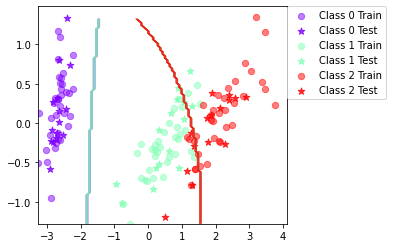

In [134]:
%matplotlib inline
plotBoundary(BayesClassifier(), dataset='iris',split=0.7)

## Boosting functions to implement

The lab descriptions state what each function should do.

### Assignment 4

In [135]:
X, y = genBlobs()

W = np.ones((X.shape[0],1))/float(X.shape[0])

mu1, sigma1 = mlParams(X, y)
mu2, sigma2 = mlParams(X, y, W)

In [136]:
# in: base_classifier - a classifier of the type that we will boost, e.g. BayesClassifier
#                   X - N x d matrix of N data points
#              labels - N vector of class labels
#                   T - number of boosting iterations
# out:    classifiers - (maximum) length T Python list of trained classifiers
#              alphas - (maximum) length T Python list of vote weights
def trainBoost(base_classifier, X, labels, T=10):
    # these will come in handy later on
    Npts,Ndims = np.shape(X)

    classifiers = [] # append new classifiers to this list
    alphas = [] # append the vote weight of the classifiers to this list

    # The weights for the first iteration
    wCur = np.ones((Npts,1))/float(Npts)

    for i_iter in range(0, T):
        # a new classifier can be trained like this, given the current weights
        classifiers.append(base_classifier.trainClassifier(X, labels, wCur))

        # do classification for each point
        vote = classifiers[-1].classify(X)
        
   
        # TODO: Fill in the rest, construct the alphas etc.
        # ==========================
        
        delta = np.reshape((vote == labels), (Npts,1))

        err = np.sum(wCur * (1 - delta)) + 1e-20
        alpha = 1/2 * (np.log(1-err) - np.log(err))
        alphaSign = (delta-.5)/(-.5)
        wCur = wCur * (np.exp(alphaSign*alpha))
        wCur = wCur/ np.sum(wCur)
        alphas.append(alpha) # you will need to append the new alpha
        # ==========================
        
    return classifiers, alphas

# in:       X - N x d matrix of N data points
# classifiers - (maximum) length T Python list of trained classifiers as above
#      alphas - (maximum) length T Python list of vote weights
#    Nclasses - the number of different classes
# out:  yPred - N vector of class predictions for test points
def classifyBoost(X, classifiers, alphas, Nclasses):
    Npts = X.shape[0]
    Ncomps = len(classifiers)

    # if we only have one classifier, we may just classify directly
    if Ncomps == 1:
        return classifiers[0].classify(X)
    else:
        votes = np.zeros((Npts,Nclasses))

        # TODO: implement classificiation when we have trained several classifiers!
        # here we can do it by filling in the votes vector with weighted votes
        # ==========================
        
        for i in range(Ncomps):
            classified = classifiers[i].classify(X)
            for j in range(Npts):
                votes[j][classified[j]] += alphas[i]
                
                
        
        # ==========================
        # one way to compute yPred after accumulating the votes
        return np.argmax(votes,axis=1)

The implemented functions can now be summarized another classifer, the `BoostClassifier` class. This class enables boosting different types of classifiers by initializing it with the `base_classifier` argument. No need to add anything here.

In [137]:
# NOTE: no need to touch this
class BoostClassifier(object):
    def __init__(self, base_classifier, T=10):
        self.base_classifier = base_classifier
        self.T = T
        self.trained = False

    def trainClassifier(self, X, labels):
        rtn = BoostClassifier(self.base_classifier, self.T)
        rtn.nbr_classes = np.size(np.unique(labels))
        rtn.classifiers, rtn.alphas = trainBoost(self.base_classifier, X, labels, self.T)
        rtn.trained = True
        return rtn

    def classify(self, X):
        return classifyBoost(X, self.classifiers, self.alphas, self.nbr_classes)

## Run some experiments

Call the `testClassifier` and `plotBoundary` functions for this part.

### Assignment 5

#### 1. Is there any improvement in classifcation accuracy? Why/why not?

Yes there is with the simple explaination that multiple classifications now agree on a result based on voting.

#### 2. Plot the decision boundary of the boosted classifer on iris and compare it with that of the basic. What differences do you notice? Is the boundary of the boosted version more complex?

The boundary itself is not more complex. Its rather more accurate in between the clusters while the single classifier could not make that distinction.

#### 3.  Can we make up for not using a more advanced model in the basic classifer (e.g. independent features) by using boosting?

Yes we can. By using multiple classifiers which accurate different part of the dataset, we get a better vote because we eliminate bias for each model with the help of group vote.

In [138]:
testClassifier(BoostClassifier(BayesClassifier(), T=10), dataset='iris',split=0.7)

Trial: 0 Accuracy 95.6
Trial: 10 Accuracy 97.8
Trial: 20 Accuracy 93.3
Trial: 30 Accuracy 93.3
Trial: 40 Accuracy 97.8
Trial: 50 Accuracy 93.3
Trial: 60 Accuracy 95.6
Trial: 70 Accuracy 95.6
Trial: 80 Accuracy 93.3
Trial: 90 Accuracy 93.3
Final mean classification accuracy  94.5 with standard deviation 2.92


In [139]:
testClassifier(BoostClassifier(BayesClassifier(), T=10), dataset='vowel',split=0.7)

Trial: 0 Accuracy 68.2
Trial: 10 Accuracy 68.8
Trial: 20 Accuracy 74
Trial: 30 Accuracy 70.1
Trial: 40 Accuracy 67.5
Trial: 50 Accuracy 69.5
Trial: 60 Accuracy 72.1
Trial: 70 Accuracy 68.8
Trial: 80 Accuracy 73.4
Trial: 90 Accuracy 70.8
Final mean classification accuracy  71.3 with standard deviation 4.62


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

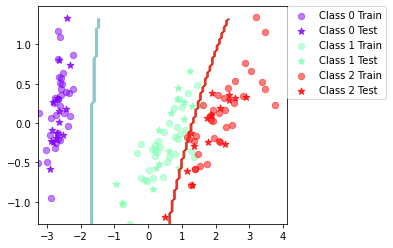

In [140]:
%matplotlib inline
plotBoundary(BoostClassifier(BayesClassifier()), dataset='iris',split=0.7)

Now repeat the steps with a decision tree classifier.

In [141]:
testClassifier(DecisionTreeClassifier(), dataset='iris', split=0.7)

Trial: 0 Accuracy 95.6
Trial: 10 Accuracy 100
Trial: 20 Accuracy 91.1
Trial: 30 Accuracy 91.1
Trial: 40 Accuracy 93.3
Trial: 50 Accuracy 91.1
Trial: 60 Accuracy 88.9
Trial: 70 Accuracy 88.9
Trial: 80 Accuracy 93.3
Trial: 90 Accuracy 88.9
Final mean classification accuracy  92.4 with standard deviation 3.71


In [142]:
testClassifier(BoostClassifier(DecisionTreeClassifier(), T=10), dataset='iris',split=0.7)

Trial: 0 Accuracy 95.6
Trial: 10 Accuracy 100
Trial: 20 Accuracy 95.6
Trial: 30 Accuracy 93.3
Trial: 40 Accuracy 93.3
Trial: 50 Accuracy 95.6
Trial: 60 Accuracy 88.9
Trial: 70 Accuracy 93.3
Trial: 80 Accuracy 93.3
Trial: 90 Accuracy 93.3
Final mean classification accuracy  94.6 with standard deviation 3.65


In [143]:
testClassifier(DecisionTreeClassifier(), dataset='vowel',split=0.7)

Trial: 0 Accuracy 63.6
Trial: 10 Accuracy 68.8
Trial: 20 Accuracy 63.6
Trial: 30 Accuracy 66.9
Trial: 40 Accuracy 59.7
Trial: 50 Accuracy 63
Trial: 60 Accuracy 59.7
Trial: 70 Accuracy 68.8
Trial: 80 Accuracy 59.7
Trial: 90 Accuracy 68.2
Final mean classification accuracy  64.1 with standard deviation 4


In [144]:
testClassifier(BoostClassifier(DecisionTreeClassifier(), T=10), dataset='vowel',split=0.7)

Trial: 0 Accuracy 85.1
Trial: 10 Accuracy 90.3
Trial: 20 Accuracy 87.7
Trial: 30 Accuracy 93.5
Trial: 40 Accuracy 83.1
Trial: 50 Accuracy 79.9
Trial: 60 Accuracy 90.3
Trial: 70 Accuracy 85.1
Trial: 80 Accuracy 82.5
Trial: 90 Accuracy 85.1
Final mean classification accuracy  86.6 with standard deviation 3.07


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

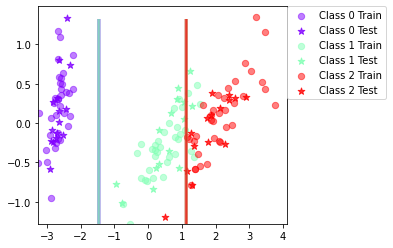

In [145]:
%matplotlib inline
plotBoundary(DecisionTreeClassifier(), dataset='iris',split=0.7)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

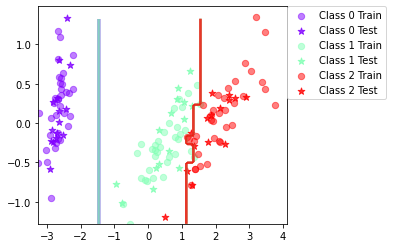

In [146]:
%matplotlib inline
plotBoundary(BoostClassifier(DecisionTreeClassifier(), T=10), dataset='iris',split=0.7)

### Assigment 7.

#### If you had to pick a classifer, naive Bayes or a decision tree or the boosted versions of these, which one would you pick? Motivate from the following criteria:
- Outliers
    - Naive Bayes without boosting because the outliers will be accounted by the weights.
- Irrelevant inputs: part of the feature space is irrelevant
    - Decision Trees with boosting because it will only acknowledge the maximum information gain.
- Predictive power
    - The Decision Trees with boosing got the best result for the iris and vowel datasets. 
- Mixed types of data: binary, categorical or continuous features, etc.
    - Decision Trees are able to have mixed types which Naive Bayes cannot. In which you then have to make continous data into categorical to 
- Scalability: the dimension of the data, D, is large or the number of instances, N, is large, or both.

## Bonus: Visualize faces classified using boosted decision trees

Note that this part of the assignment is completely voluntary! First, let's check how a boosted decision tree classifier performs on the olivetti data. Note that we need to reduce the dimension a bit using PCA, as the original dimension of the image vectors is `64 x 64 = 4096` elements.

In [147]:
testClassifier(BayesClassifier(), dataset='olivetti',split=0.7, dim=20)

Trial: 0 Accuracy 88.3
Trial: 10 Accuracy 90.8
Trial: 20 Accuracy 85
Trial: 30 Accuracy 89.2
Trial: 40 Accuracy 89.2
Trial: 50 Accuracy 84.2
Trial: 60 Accuracy 91.7
Trial: 70 Accuracy 82.5
Trial: 80 Accuracy 81.7
Trial: 90 Accuracy 86.7
Final mean classification accuracy  87.7 with standard deviation 3.03


In [148]:
testClassifier(BoostClassifier(DecisionTreeClassifier(), T=10), dataset='olivetti',split=0.7, dim=20)

Trial: 0 Accuracy 71.7
Trial: 10 Accuracy 77.5
Trial: 20 Accuracy 76.7
Trial: 30 Accuracy 70.8
Trial: 40 Accuracy 73.3
Trial: 50 Accuracy 65.8
Trial: 60 Accuracy 75.8
Trial: 70 Accuracy 71.7
Trial: 80 Accuracy 67.5
Trial: 90 Accuracy 73.3
Final mean classification accuracy  70.7 with standard deviation 6.72


You should get an accuracy around 70%. If you wish, you can compare this with using pure decision trees or a boosted bayes classifier. Not too bad, now let's try and classify a face as belonging to one of 40 persons!

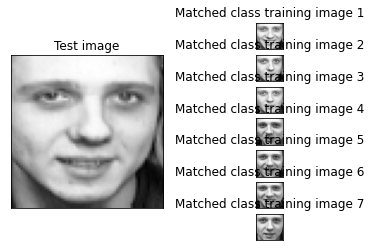

In [149]:
%matplotlib inline
X,y,pcadim = fetchDataset('olivetti') # fetch the olivetti data
xTr,yTr,xTe,yTe,trIdx,teIdx = trteSplitEven(X,y,0.7) # split into training and testing
pca = decomposition.PCA(n_components=20) # use PCA to reduce the dimension to 20
pca.fit(xTr) # use training data to fit the transform
xTrpca = pca.transform(xTr) # apply on training data
xTepca = pca.transform(xTe) # apply on test data
# use our pre-defined decision tree classifier together with the implemented
# boosting to classify data points in the training data
classifier = BoostClassifier(DecisionTreeClassifier(), T=10).trainClassifier(xTrpca, yTr)
yPr = classifier.classify(xTepca)
# choose a test point to visualize
testind = random.randint(0, xTe.shape[0]-1)
# visualize the test point together with the training points used to train
# the class that the test point was classified to belong to
visualizeOlivettiVectors(xTr[yTr == yPr[testind],:], xTe[testind,:])